In [1]:
# ==========================
# 2D Embeddings for ARI Comparison
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, FastICA, KernelPCA
from sklearn.manifold import SpectralEmbedding, TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [3]:
# --- Load and preprocess ---
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
random_state = 42

# Subsample for speed
size = 5000
idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X[idx], y[idx]
X_scaled = StandardScaler().fit_transform(X_sub)

In [4]:
# --- PCA (2D) ---
pca = PCA(n_components=2, random_state=random_state)
X_pca_2d = pca.fit_transform(X_scaled)

# --- NMF (2D) ---
X_nonneg = X_sub - X_sub.min()  # ensure nonnegativity
nmf = NMF(n_components=2, init="nndsvda", random_state=random_state, max_iter=400)
X_nmf_2d = nmf.fit_transform(X_nonneg)

# --- ICA (2D) ---
ica = FastICA(n_components=2, random_state=random_state, max_iter=500)
X_ica_2d = ica.fit_transform(X_scaled)

# --- Kernel PCA (2D tuned) ---
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=1e-03, random_state=random_state)
X_kpca_2d = kpca.fit_transform(X_scaled)

# --- Spectral Embedding (2D tuned) ---
se = SpectralEmbedding(n_components=2, n_neighbors=4, random_state=random_state)
X_spec_2d = se.fit_transform(X_scaled)

# --- t-SNE (2D tuned) ---
tsne = TSNE(n_components=2, perplexity=5, learning_rate=100, random_state=random_state, init="pca")
X_tsne_2d = tsne.fit_transform(X_scaled)

# --- UMAP (2D tuned) ---
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=0.3,
                    metric='euclidean', random_state=random_state)
X_umap_2d = reducer.fit_transform(X_scaled)

# --- Store all embeddings ---
embeddings_2d = {
    "PCA": X_pca_2d,
    "NMF": X_nmf_2d,
    "ICA": X_ica_2d,
    "Kernel PCA": X_kpca_2d,
    "Spectral Embedding": X_spec_2d,
    "t-SNE": X_tsne_2d,
    "UMAP": X_umap_2d
}

print("All 2D embeddings computed successfully.")

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


All 2D embeddings computed successfully.


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

ari_scores = {}
for name, emb in embeddings_2d.items():
    kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
    preds = kmeans.fit_predict(emb)
    ari = adjusted_rand_score(y_sub, preds)
    ari_scores[name] = ari
    print(f"{name:20s} ARI = {ari:.4f}")

PCA                  ARI = 0.1352
NMF                  ARI = 0.1028
ICA                  ARI = 0.1171
Kernel PCA           ARI = 0.1559
Spectral Embedding   ARI = 0.2648
t-SNE                ARI = 0.4715
UMAP                 ARI = 0.5060


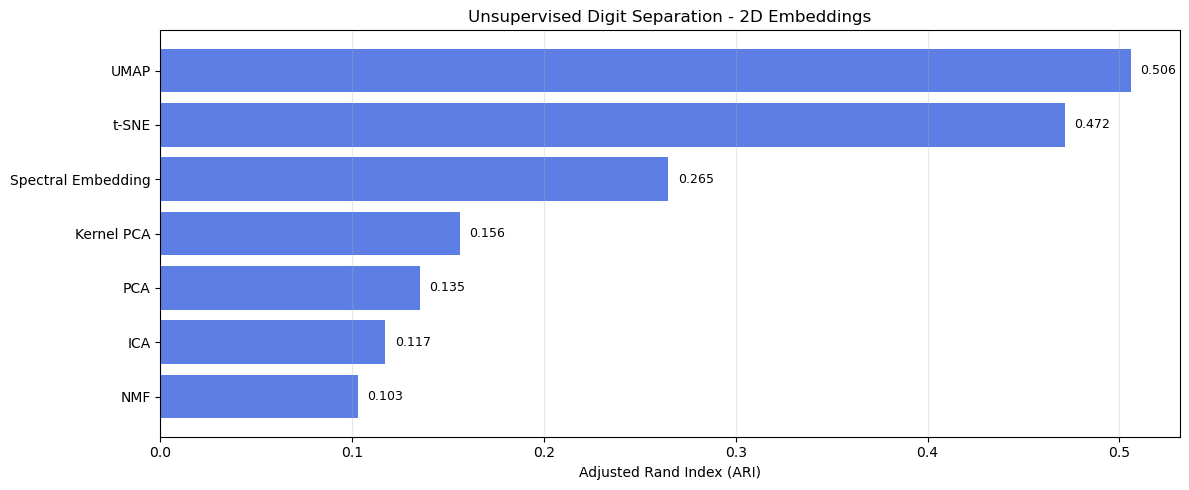

In [10]:
# ==========================
# ARI Comparison Across Methods
# ==========================

# --- Sort by ARI descending ---
sorted_methods = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)
methods, scores = zip(*sorted_methods)

# --- Plot ---
plt.figure(figsize=(12,5))
bars = plt.barh(methods, scores, color='royalblue', alpha=0.85)
plt.xlabel("Adjusted Rand Index (ARI)")
plt.title("Unsupervised Digit Separation - 2D Embeddings")
plt.grid(axis='x', alpha=0.3)

# Annotate bars
for bar, score in zip(bars, scores):
    plt.text(score + 0.005, bar.get_y() + bar.get_height()/2,
             f"{score:.3f}", va='center', fontsize=9)

plt.gca().invert_yaxis()  # Highest score at top
plt.tight_layout()
plt.savefig("docs/ari_comparison_hist.png", dpi=150)
plt.show()
